In [1]:
import torch
from torchvision import transforms
import torch
from torch import nn
import pytorch_lightning as pl

print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")

True


In [2]:
class LitMobileNetTransferLearning(pl.LightningModule):
    def __init__(self, base_model, num_target_classes, lr=1e-3):
        super().__init__()

        # num of target classes
        self.num_target_classes = num_target_classes

        # loss
        self.loss = nn.CrossEntropyLoss()

        # learning rate for optimizer
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

        # network layer
        # init a pretrained weight from base model
        backbone = base_model
        num_filters = backbone.classifier[0].in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify num_target_classess
        self.classifier = nn.Linear(num_filters, self.num_target_classes)

    def forward(self, x: torch.Tensor):
        '''method used for inference input -> output'''
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'train_loss': loss, 'train_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'val_loss': loss, 'val_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'test_loss': loss, 'test_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

    def configure_optimizers(self):
        '''defines model optimizer'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y, "multiclass", num_classes=self.num_target_classes)
        return preds, loss, acc

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hiseulgi. Use `wandb login --relogin` to force relogin


True

In [4]:
# download checkpoint locally (if not already cached)
checkpoint_reference = "hiseulgi/banana-leaf-diseases/model-7gtc518c:v49"

run = wandb.init(project="banana-leaf-diseases")
artifact = run.use_artifact(checkpoint_reference, type="model")
artifact_dir = artifact.download()
# artifact_dir = "artifacts/model-7gtc518c:v49/model.ckpt"

wandb:   1 of 1 files downloaded.  


In [53]:
import os
import time
import requests

def download_image(url, save_dir="datasets/real-data"):
    try:
        # Ambil konten gambar dari URL
        response = requests.get(url)
        response.raise_for_status()

        # Generate nama file berdasarkan timestamp Unix
        timestamp = int(time.time())
        file_name = f"{timestamp}.jpg"
        file_path = os.path.join(save_dir, file_name)

        # Simpan gambar ke direktori yang diinginkan
        with open(file_path, "wb") as file:
            file.write(response.content)

        print(f"Gambar telah diunduh dan disimpan sebagai {file_name}")
        
        return save_dir+"/"+file_name
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

In [86]:
from pathlib import Path

# load checkpoint
model = LitMobileNetTransferLearning.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")
model_cpu = LitMobileNetTransferLearning.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", map_location=torch.device("cpu"), encoder_map_location=torch.device("cpu"))

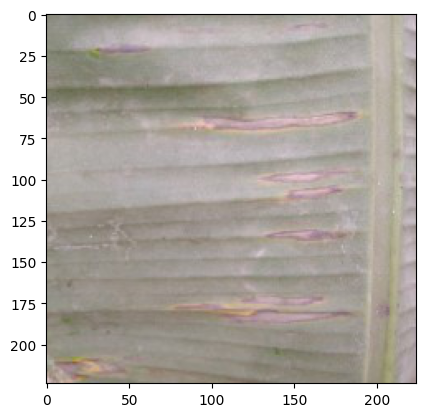

In [83]:
from PIL import Image
import matplotlib.pyplot as plt

# downloaded_dir = download_image("https://www.researchgate.net/profile/Olinto-Pereira/publication/257828806/figure/fig3/AS:667809503784965@1536229601331/Leaf-spot-symptoms-on-an-old-leaf-of-Musa-paradisiaca-cv-Caipira.png")
# image_input = Image.open(downloaded_dir)

image_input = Image.open("datasets/BananaLSD/OriginalSet/sigatoka/4.jpeg")
# image_input = Image.open("datasets/BananaLSD/OriginalSet/sigatoka/4.jpeg")
plt.imshow(image_input);

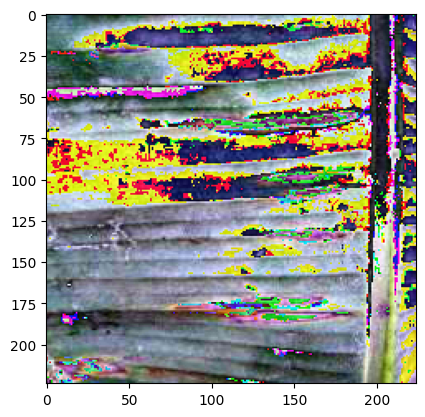

In [84]:
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transformed_image = predict_transform(image_input)
transformed_image_pil = transforms.ToPILImage()(transformed_image)
plt.imshow(transformed_image_pil);

In [89]:
class_names = ['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']

# predict data
model.eval()
with torch.inference_mode():
    # x = transformed_image.unsqueeze(0).to("cuda")
    x = transformed_image.unsqueeze(0)
    
    logits = model_cpu(x)
    
    percentage = torch.softmax(logits.squeeze(), dim=0)
    
    pred = torch.argmax(percentage)
    print(f"Predicted: {percentage} - {pred} - {class_names[pred]}")

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same